# 3D convection, periodic

v2.81 13 July 2018, by Brian Fiedler

*A work in progress*

This notebook reproduces some results from three publications.

### Cell broadening, 1993

Fiedler, B. H., 1993: [Cell broadening in three-dimensional thermal convection between poorly conducting boundaries](https://www.researchgate.net/publication/266442575_Cell_broadening_in_three-dimensional_thermal_convection_between_poorly_conducting_boundaries). Beitr. Phys. Atmosph. 66, 173-181.
 
Set `nexp=1` below.  You can make an animation similar to: http://12characters.net/explore/R4.html


 
### Cell broadening, 1994 

Fiedler, B. H. and M. Khairoutdinov, 1994: [Cell broadening in three-dimensional thermal convection between poorly conducting boundaries: Large eddy simulations](https://www.researchgate.net/publication/326254880_Cell_broadening_in_three-dimensional_thermal_convection_between_poorly_conducting_boundaries_Large_eddy_simulations). Beitr. Phys. Atmosph. 67, 235-241.
 
Set `nexp=2` below.  You can make an animation similar to: http://12characters.net/explore/R128.html

 
### Dust devil, 2001
Fiedler, B. H. and K. Kanak, 2001: [Rayleigh-Benard Convection as a tool for studying dust devils](https://rmets.onlinelibrary.wiley.com/doi/epdf/10.1006/asle.2001.0046). Atmos. Sci. Letters

Set `nexp=91` below.  You can make an animation similar to: http://12characters.net/explore/DustDevil.html

### Fiedler, 1999

Fiedler, B. H.: [Thermal convection in a layer bounded by uniform heat flux: Application of a strongly nonlinear analytical solution](https://www.researchgate.net/publication/233115685_Thermal_convection_in_a_layer_bounded_by_uniform_heat_flux_Application_of_a_strongly_nonlinear_analytical_solution). Geophysical & Astrophysical Fluid Dynamics 91(3-4):223-250


$\newcommand{\V}[1]{\vec{\boldsymbol{#1}}}$
$\newcommand{\I}[1]{\widehat{\boldsymbol{\mathrm{#1}}}}$
$\newcommand{\B}[1]{\overline{#1}}$ 
$\newcommand{\pd}[2]{\frac{\partial#1}{\partial#2}}$
$\newcommand{\dd}[2]{\frac{\D#1}{\D#2}}$
$\newcommand{\pdt}[1]{\frac{\partial#1}{\partial t}}$
$\newcommand{\ddt}[1]{\frac{\D#1}{\D t}}$
$\newcommand{\D}{\mathrm{d}}$
$\newcommand{\Ii}{\I{\imath}}$
$\newcommand{\Ij}{\I{\jmath}}$
$\newcommand{\Ik}{\I{k}}$
$\newcommand{\VU}{\V{U}}$
$\newcommand{\del}{\boldsymbol{\nabla}}$
$\newcommand{\dt}{\cdot}$
$\newcommand{\x}{\times}$
$\newcommand{\dv}{\del\cdot}$
$\newcommand{\curl}{\del\times}$
$\newcommand{\lapl}{\nabla^2}$
$\newcommand{\VI}[1]{\left\langle#1\right\rangle}$
$\newcommand{\wc}{W_c}$
$\newcommand{\bc}{B_c}$
$\newcommand{\dfu}{\epsilon}$
$\newcommand{\wh}{\hat{w}}$
$\newcommand{\bh}{\hat{b}}$
$\newcommand{\iRo}{f^*}$
$\require{color}$

In [1]:
# imports 
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display,clear_output, Image, Markdown
import time as Time
import math, os, glob
import numpy as np
import scipy.fftpack
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import urllib.request
import shutil

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this line, if you have downloaded metr4323.css to your computer

## The governing equations
We prognosticate with the following dimensional equations.  Except for the diffusion terms,
they should look familiar.

$$
\pdt{u} + u \pd{u}{x} + v \pd{u}{y} + w \pd{u}{z}= - \pd{P}{x} + f v + \nu \lapl u
$$

$$
\pdt{v} + u \pd{v}{x} + v \pd{v}{y} + w \pd{v}{z}=  - \pd{P}{y} - f u + \nu \lapl v
$$

$$
\pdt{w} + u \pd{w}{x} + v \pd{w}{y} + w \pd{w}{z}= - \pd{P}{z} + b + \nu \lapl w
$$

$$
\pd{u}{x} + \pd{v}{y} + \pd{w}{z}  = 0
$$

$$
\pdt{B} + u \pd{B}{x} + v \pd{B}{y} + w \pd{B}{z} = \kappa \lapl B
$$

The boundary conditions for $u$ and $v$ st the top and bottom will be stress-free. 

The boundary condition on $B$ at $z=0$ will be close to constant flux:
$$
-K\pd{B}{z} = F_0  -\alpha b
$$
where $b$ will be defined below.
The top boundary $z=H$ will be exactly constant flux:
$$
-K\pd{B}{z} = F_1
$$
Here we have defined a *total buoyancy*:
$$
B \equiv \B{B}(z) + B_0(t) + b
$$
For analysis of convective instability, it is useful to assign $\B{B}$ as the (unstable) stratification of buoyancy that exists in the absence of the (resolved) motion. 
We require:
$$
\pdt{B_0}  = \kappa \lapl \B{B}
$$
with boundary condition at z=0:
$$
-\kappa \pd{\B{B}}{z} = F_0 
$$
with boundary condition at z=H:
$$
-\kappa \pd{\B{B}}{z} = F_1 
$$
Often we will take $F_1=0$, so the layer is heated only from below and insulated at the top.

This gives a solution
$$
B_0 = \frac{F_0 - F_1}{H} t
$$
and
$$
\B{B} = - \frac{F_0}{\kappa} z  + \frac{F_0-F_1}{\kappa} \frac{z^2}{2H}
$$
So the boundary condition on $b$ at z=0
$$
K \pd{b}{z} = \alpha b 
$$
and at $z=H$:
$$
K \pd{b}{z} = 0
$$
The prognostic equation for b is:
$$
\pdt{b} + u \pd{b}{x} + v \pd{b}{y} + w \pd{b}{z} = - w \pd{\B{B}}{z} + \kappa \lapl b
$$
The above form is convient for stability analyis. For the model pronognsis it is convient to
let 
$c \equiv b + \B{B}$
and so prognosticate with:
$$
\pdt{c} + u \pd{c}{x} + v \pd{c}{y} + w \pd{c}{z} =   \kappa \lapl c - \pdt{B_0}
$$
with boundary conditions
$$
K \pd{c}{z} = -F_0 + \alpha  c 
$$
where we used $\B{B}(0)=0$
and at $z=H$:
$$
K \pd{c}{z} = - F_1 
$$


## Nondimensionalization
In vigourous convective motion we anticipate that a positive bouyancy anomaly of scale $\bc$ is correlated with an updraft with upward velocity of scale $\wc$.  If the convective motion dominates the vertical transport of buouyancy coming in from the lower boundary, these scales are related by:
$$
\wc \bc = F_0
$$
The layer has depth $H$. The buoyancy anomaly can also related to $\wc$ by assuming the work it does generates the kinetic energy of the updraft.  So we choose to specify this requirement with:
$$
\bc H = \wc^2
$$
We use the depth of the layer $H$ as the length scale, $H/\wc$ as the time scale, and
$\wc H$ as the diffusivity scale.

We use a * to denote a *dimensionless* quantity.    Therefore:

$$
(x,z) = (x^*,z^*)H  \qquad
t = t^* \frac{H}{\wc} \qquad
(u,v,w) = (u^*,v^*,w^*) \wc\qquad
P = P^* \wc^2  \qquad
B = B^* \bc 
$$

Substituting the above definitions into the dimensional equations and then multipling all terms by
$H/\wc^2$:

$$
\pd{u^*}{t^*} + u^* \pd{u^*}{x^*} + v^* \pd{u^*}{y^*} + w^* \pd{u^*}{z^*}=
- \pd{P^*}{x^*} + \frac{f H}{\wc} v^*  + \frac{\nu}{\wc H} {\lapl}^* u^*
$$


$$
\pd{v*}{t^*} + u^* \pd{v^*}{x^*} + v^* \pd{v^*}{y^*} + w^* \pd{v^*}{z^*}= 
- \pd{P^*}{y^*} - \frac{f H}{\wc} u^* + \frac{\nu}{\wc H} {\lapl}^* v^*
$$

$$
\pd{w^*}{t^*} + u^* \pd{w^*}{x^*} + v^* \pd{w^*}{y^*} + w^* \pd{w^*}{z^*}
= - \pd{P^*}{z^*} + b^* + \frac{\nu}{\wc H} {\lapl}^* w^*
$$

$$
\pd{u^*}{x^*} + \pd{v^*}{y^*} + \pd{w^*}{z^*}  = 0
$$

$$
\pd{b^*}{t^*} + u^* \pd{b^*}{x^*} + v^* \pd{b^*}{y^*} + w^* \pd{b^*}{z^*} = -w^*\pd{\B{B}^*}{z^*} + \frac{\kappa}{\wc H} {\lapl}^* b^*
$$

The buoyancy boundary condition at $z=0$ is:
$$
\frac{\kappa}{\wc H} \pd{b^*}{z^*} = \frac{\alpha}{\wc} b^* 
$$
or in terms of $c^*$:
$$
\frac{\kappa}{\wc H} \pd{c^*}{z^*} = -1 + \frac{\alpha}{\wc} c^* 
$$
which would be used with:
$$
\pd{c^*}{t^*} + u^* \pd{c^*}{x^*} + v^* \pd{c^*}{y^*} + w^* \pd{c^*}{z^*} =  \frac{\kappa}{\wc H} {\lapl}^* c^* -1 + F_1/F_0
$$
For application to a turbulent atmospheric bounday layer, we interpret the $\nu$ and $\kappa$ as eddy diffusivities
and for simplicty assume $\nu=\kappa$.

We will write
$$
\dfu \equiv \frac{\kappa}{\wc H} \equiv \frac{\nu}{\wc H}
$$
and 
$$
\Gamma  \equiv \frac{\alpha}{\wc} 
$$
$$
R = \frac{fH}{\wc}
$$
$$
\beta = 1- F_1/F_0
$$
$$
\iRo = \frac{f H}{\wc}
$$


As is the custom, we drop the * on all the dimensionless quantities, and leave the understanding that the variables are now dimensionless.

$$
\pd{u}{t} + u \pd{u}{x} + v \pd{u}{y} + w \pd{u}{z}=
- \pd{P}{x} + \iRo v  + \dfu \lapl u
$$


$$
\pd{v}{t} + u \pd{v}{x} + v \pd{v}{y} + w \pd{v}{z}= 
- \pd{P}{y} - \iRo u + \dfu {\lapl} v
$$

$$
\pd{w}{t} + u \pd{w}{x} + v \pd{w}{y} + w \pd{w}{z}
= - \pd{P}{z} + b + \dfu {\lapl} w
$$

$$
\pd{u}{x} + \pd{v}{y} + \pd{w}{z}  = 0
$$

$$
\pd{b}{t} + u \pd{b}{x} + v \pd{b}{y} + w \pd{b}{z} = w\frac{1- \beta z}{\dfu} + \dfu {\lapl} b
$$

The buoyancy boundary condition at $z=0$ is:
$$
\dfu \pd{b}{z} = \Gamma b 
$$
and $z=1$ is:
$$
\dfu \pd{b}{z} = 0
$$
If we are using:
$$
\pd{c}{t} + u \pd{c}{x} + v \pd{c}{y} + w \pd{c}{z} =  \dfu {\lapl} c - \beta
$$
then at $z=0$:
$$
\dfu \pd{c}{z} = -1 + \Gamma c 
$$
and at $z=1$:
$$
\dfu \pd{c}{z} = -1 +\beta
$$
The model below uses the Arakawa C-grid with $c$ collocated with $P$. A virtue of computing with $c$ rather than $b$ is that we cen prognosticate $c$ in "flux form". This will insure $c$ is globally conserved, meaning there are no  advection terms that could spuriously generate or diminish $c$.
$$
\pd{c}{t}  = -\del \dt \left( \V{U}c - \dfu \del c \right) - \beta
$$

## Linear stability analysis


I leave future scholars to explore the effect of the Coriolis force, so here we take $\iRo=0$.  We conduct a linear stability analysis wtih $v=0$. That leaves 4 dynamical equations, the linear versions of which are:
$$
\pd{u}{t} = - \pd{P}{x}  + \dfu \lapl u
$$

$$
\pd{w}{t} = - \pd{P}{z} + b + \dfu {\lapl} w
$$

$$
\pd{u}{x} + \pd{v}{y} + \pd{w}{z}  = 0
$$

$$
\pd{b}{t}  = w \frac{1- \beta z}{\dfu} + \dfu {\lapl} b
$$

These equations can be combined to eliminate $u$ and $P$:
$$
\left( \pdt{} - \dfu\lapl \right) \lapl w = \pd{^2b}{x^2}
$$
$$
\left( \pdt{} - \dfu\lapl \right) b = \frac{w}{\dfu} (1 - \beta z)
$$
We seek seperable solutions:
$$
w = \wh(z) \cos(kx)e^{\sigma t} \qquad b = \bh(z) \cos(kx) e^{\sigma t}
$$

The primary goal is to determine how $\sigma$ depends on $k$,  $\Gamma$, $\beta$ and $\dfu$.

With $D\equiv \pd{}{z}$:
$$
\left(\sigma + \dfu k^2 - \dfu D^2 \right)\left(k^2 -  D^2 \right)\wh = -k^2 \bh
$$
$$
\left(\sigma + \dfu k^2 - \dfu D^2 \right)\bh = \frac{1}{\dfu}(1 - \beta z) \wh
$$
The boundary conditions at $z=0$ are:
$$
\dfu D\bh = \Gamma \bh \qquad \wh=0 \qquad D^2\wh = 0
$$
and at $z=1$:
$$
\dfu D\bh = 0 \qquad \wh=0 \qquad D^2\wh = 0
$$
We seek a perturbation solution valid for small $k$:
$$
\bh = b_0 + k^2b_2 + \ldots
$$
$$
\wh = k^2w_2 + k^4w_4 + \ldots
$$
$$
\sigma = k^2s_2 + k^4s_4 + \ldots
$$
$$
\frac{1}{\dfu}\Gamma = k^2 g
$$
The $O(k^0)$ equations are:
$$
D^2b_0 = 0
$$
with $Db_0 = 0$ at $z=0$ and $z=1$.
A solution is
$$
b_0 = 1
$$
The $O(k^2)$ equations are:
$$
\dfu D^4 w_2 = b_0 
$$
and
$$
\left(s_2 + \dfu \right) b_0 - \dfu D^2 b_2 = \frac{1}{\dfu}(1-\beta z) w_2 
$$

With the four boundary conditions on $w_2$, and $b_0=1$:
$$
\dfu w_2 = \frac{1}{24} z - \frac{1}{12} z ^3 + \frac{1}{24} z^4
$$
We don't need to solve for $b_2$ to achieve our goal.  Instead we apply a vertical integral $\VI{q}\equiv \int_0^1q \ dz$.
$$
\left(s_2 + \dfu \right) \VI{b_0} - \dfu  \VI{D^2b_2} = \frac{1}{\dfu}\left( \VI{w_2} - \beta \VI{z w_2} \right)  
$$
At $z=0$: 
$$Db_2 = g b_0$$
and at $z=1$:
$$Db_2 = 0 $$
so 
$$
\dfu\VI{D^2b_2} = -\dfu g
$$
$$
\dfu\VI{w_2} = \frac{1}{48} - \frac{1}{48} + \frac{1}{120} = \frac{1}{120}
$$
$$
\dfu\VI{zw_2} = \frac{1}{72} - \frac{1}{60} + \frac{1}{144} = \frac{1}{240}
$$
So the above equation is
$$
\left(s_2 + \dfu +g \right) 
= \frac{1}{\dfu^2}\left( \frac{1}{120} -\frac{\beta}{240} \right) 
$$
Which, to $O(k^2)$, is:
$$
\frac{1}{k^2} \left( \sigma + \Gamma \right) = 
\frac{1}{\dfu^2}\left( \frac{1}{120} - \frac{\beta}{240}\right) - \dfu
$$
So we reach our goal. To $O(k^2)$:
$$
\sigma = k^2 \left[ \frac{1}{\dfu^2} \left( \frac{1}{120} - \frac{\beta}{240} \right) - \dfu \right] - \Gamma
$$
Let
$$
R_0 \equiv \frac{240}{2-\beta}
$$
So
$$
\sigma = k^2 \left( \frac{1}{\dfu^2 R_0}  - \dfu \right)
- \Gamma
$$

As an example application, consider $\Gamma=0$. Instabilty occurs if:
$$
 \frac{1}{\dfu^2} \frac{1}{R_0} -  \dfu > 0
$$
or
$$
\frac{1}{\dfu^3} > R_0.
$$

With the vertical gradient in buoyancy, at onset of stability, being $1/\dfu$, we recognize $R\equiv \dfu^{-3}$ as the Rayleigh number, which has the gradient in the numerator and the product of the diffusivities in the denominator.

With $\beta=0$, the critical Rayleigh number is $R_0= 120$.
For a layer heated only from below and insulated at the top, $\beta=1$, and $R_0 = 240$.

For $\sigma>0$,
$$
\Gamma  < k^2\dfu\left[ \frac{R}{R_0} -1 \right] \equiv \Gamma_0
$$

In [3]:
#example calculation
hfbot=1
hftop=0
raycrit = 240/(hfbot+hftop)
ray_over_rayc = 64
ray = raycrit*ray_over_rayc
diffusion_coef = ray**(-1./3)
beta = 1 - hftop/hfbot

k = 2*3.1415/16 # example  
Gamma0 = k**2 * diffusion_coef* (ray_over_rayc - 1)
print(diffusion_coef,k,Gamma0)

0.04022872435856791 0.3926875 0.39081476678720145


## Some properties of two-dimensional solutions

Some steady, two-dimensional solutions can be obtained with `nexp=101`.

Below we show solutions for $w$ and $c$ at
wavelength 8 and 16, for the indicated values of $R/R_0$ and all with $\Gamma=0$  Note the "spikiness" of $w$.  Note the amplitudes increase with wavelength, and (of course) $R/R_0$.

<img src="http://metrprof.xyz/RandkStudy.png">

Below we show solutions for wavelength 16, various $\Gamma$ and all with $R/R_0=64$.  Note that amplitude decreases as $\Gamma$ increases.  Even though $\Gamma=0.2$ allows for instability at wavelength 16, that wavelength cannot be
forced to dominate the solution.

<img src="http://metrprof.xyz/GammaStudy.png">

## Adams-Bashforth scheme

In [4]:
def ab_blend(dqdt,order):
# blends the time derivatives for the 1st, 2nd and 3rd order Adams-Bashforth schemes
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")


## Some functions for the 3-D C-grid

In [5]:
##############################################    
def make3dgrid(ix,iy,iz,xmax,ymax,zmax):
# input number of desired gridpoints, and the span of the grid,
# return 3-D arrays of the x y and z coordinates at the grid points
    dx=xmax/(ix-1.)
    dy=ymax/(iy-1.)
    dz=zmax/(iz-1.)
    x1=np.linspace(0,xmax,ix)
    y1=np.linspace(0,ymax,iy)
    z1=np.linspace(0,zmax,iz)
    x=np.zeros( (iz,iy,ix) )
    y=np.zeros( (iz,iy,ix) )
    z=np.zeros( (iz,iy,ix) )
    for j in range(iy):
        for k in range(iz):
            x[k,j,:]=x1
    for i in range(ix):
        for k in range(iz):
            y[k,:,i]=y1
    for i in range(ix):
        for j in range(iy):
            z[:,j,i]=z1
    return x,y,z,dx,dy,dz

##############################################    
def advect_3d(q,u,v,w,dx,dy,dz):  #non-periodic version
# 3rd-order upwind advection
    dqdt=np.zeros(q.shape)
    dqmx=np.zeros(q.shape)
    dqpx=np.zeros(q.shape)
    dqmy=np.zeros(q.shape)
    dqpy=np.zeros(q.shape)
    dqmz=np.zeros(q.shape)
    dqpz=np.zeros(q.shape)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    dqmx[:,:,1]  = q[:,:,1]-q[:,:,0]  #1
    dqmx[:,:,2:-1] = (2*q[:,:,3:]+3*q[:,:,2:-1]-6*q[:,:,1:-2]+q[:,:,:-3])/6. #3
    dqpx[:,:,-2] = q[:,:,-1]-q[:,:,-2] #1
    dqpx[:,:,1:-2] = -(2*q[:,:,0:-3]+3*q[:,:,1:-2]-6*q[:,:,2:-1]+q[:,:,3:])/6. #3

    dqmy[:,1,:]  = q[:,1,:]-q[:,0,:] #1
    dqmy[:,2:-1,:] =  (2*q[:,3:,:]+3*q[:,2:-1,:]-6*q[:,1:-2,:]+q[:,:-3,:])/6. #3
    dqpy[:,-2,:] = q[:,-1,:]-q[:,-2,:] #1
    dqpy[:,1:-2,:] = -(2*q[:,0:-3,:]+3*q[:,1:-2,:]-6*q[:,2:-1,:]+q[:,3:,:])/6. #3

    dqmz[1,:,:]  = q[1,:,:]-q[0,:,:]  #1
    dqmz[2:-1,:,:] = (2*q[3:,:,:]+3*q[2:-1,:,:]-6*q[1:-2,:,:]+q[:-3,:,:])/6. #3
    dqpz[-2,:,:] = q[-1,:,:]-q[-2,:,:] #1
    dqpz[1:-2,:,:] = -(2*q[0:-3,:,:]+3*q[1:-2,:,:]-6*q[2:-1,:,:]+q[3:,:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy
    dqdz=np.where(w>0.,dqmz,dqpz)/dz

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    dqdt+=-w*dqdz
    return dqdt


In [6]:
def advect_3dp(q,u,v,w,dx,dy,dz,per='U'): # periodic version
# 3rd-order upwind advection
    sh = q.shape
    Q = np.zeros( (sh[0],sh[1]+4,sh[2]+4) )
    Q[:, 2:-2 , 2:-2] = q
    
    if per=='U':        
        Q[ : , :2 , 2:-2 ] = q[ : , -3:-1 , : ]
        Q[ : , -2: , 2:-2] = q[ : , 1:3 , : ]
        Q[ : , 2:-2 , :2] = q[ : , : , -3:-1 ]
        Q[ : , 2:-2 , -2:] = q[ : , : , 1:3 ]
    elif per=='u':
        Q[ : , :2 , 2:-2 ]  = q[ : , -2: , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , :2  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -3:-1 ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , 1:3 ]
    elif per=='v':
        Q[ : , :2 , 2:-2 ]  = q[ : , -3:-1 , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , 1:3  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -2: ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , :2 ] 
    elif per=='w':
        Q[ : , :2 , 2:-2 ]  = q[ : , -2: , : ]
        Q[ : , -2: , 2:-2 ] = q[ : , :2  , : ]
        Q[ : , 2:-2 , :2 ]  = q[ : , : , -2: ]
        Q[ : , 2:-2 , -2: ] = q[ : , : , :2 ] 
        
    
    dqdt=np.zeros(sh)
    dqmx=np.zeros(sh)
    dqpx=np.zeros(sh)
    dqmy=np.zeros(sh)
    dqpy=np.zeros(sh)
    dqmz=np.zeros(sh)
    dqpz=np.zeros(sh)

# "m" is difference biased to the minus side, "p" to the plus side
# must use first order "#1" if too close to wall
    
    dqmx[:,:,:] =  (2*Q[:,2:-2,3:-1] + 3*Q[:,2:-2,2:-2] - 6*Q[:,2:-2,1:-3] + Q[:,2:-2,:-4])/6. 
    dqpx[:,:,:] = -(2*Q[:,2:-2,1:-3] + 3*Q[:,2:-2,2:-2] - 6*Q[:,2:-2,3:-1] + Q[:,2:-2,4:] )/6.
    
    dqmy[:,:,:] =  (2*Q[:,3:-1,2:-2] + 3*Q[:,2:-2,2:-2] - 6*Q[:,1:-3,2:-2] + Q[:,:-4,2:-2])/6. 
    dqpy[:,:,:] = -(2*Q[:,1:-3,2:-2] + 3*Q[:,2:-2,2:-2] - 6*Q[:,3:-1,2:-2] + Q[:,4:,2:-2] )/6. 

    dqmz[1,:,:]  = q[1,:,:]-q[0,:,:]  #1
    dqmz[2:-1,:,:] = (2*q[3:,:,:]+3*q[2:-1,:,:]-6*q[1:-2,:,:]+q[:-3,:,:])/6. #3
    dqpz[-2,:,:] = q[-1,:,:]-q[-2,:,:] #1
    dqpz[1:-2,:,:] = -(2*q[0:-3,:,:]+3*q[1:-2,:,:]-6*q[2:-1,:,:]+q[3:,:,:])/6. #3

# use derivatives biased to the upwind side:
    dqdx=np.where(u>0.,dqmx,dqpx)/dx
    dqdy=np.where(v>0.,dqmy,dqpy)/dy
    dqdz=np.where(w>0.,dqmz,dqpz)/dz

# advective terms:
    dqdt+=-u*dqdx
    dqdt+=-v*dqdy
    dqdt+=-w*dqdz
    return dqdt


In [7]:
# divergence on the C-grid
def div_Cgrid(u,v,w,dx,dy,dz):
    return (u[:,:,1:]-u[:,:,:-1])/dx + (v[:,1:,:]-v[:,:-1,:])/dy + (w[1:,:,:]-w[:-1,:,:])/dz

In [8]:
#Interpolators for the C grid
def v_to_u(v,bnd='slip'):
    iz,iy,ix = v.shape
    atu=np.zeros((iz,iy-1,ix+1))
    atu[:,:,1:-1] = .25*( v[:,:-1,:-1] + v[:,:-1,1:] + v[:,1:,:-1] + v[:,1:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( v[:,:-1,-1] + v[:,:-1,0] + v[:,1:,-1] + v[:,1:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu

def w_to_u(w,bnd='slip'):
    iz,iy,ix = w.shape
    atu=np.zeros((iz-1,iy,ix+1))
    atu[:,:,1:-1] = .25*( w[:-1,:,:-1] + w[:-1,:,1:] + w[1:,:,:-1] + w[1:,:,1:] )
    if bnd=='slip':
        atu[:,:,0] = atu[:,:,1]
        atu[:,:,-1] = atu[:,:,-2]
    elif bnd=='per':
        atu[:,:,0] = .25*( w[:-1,:,-1] + w[:-1,:,0] + w[1:,:,-1] + w[1:,:,0] )
        atu[:,:,-1] = atu[:,:,0]
    else:
        sys.exit('nothing for: '+bnd)
    return atu

def u_to_v(u,bnd='slip'):
    iz,iy,ix = u.shape
    atv=np.zeros((iz,iy+1,ix-1))
    atv[:,1:-1,:] = .25*( u[:,:-1,:-1] + u[:,:-1,1:] + u[:,1:,:-1] + u[:,1:,1:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( u[:,-1,:-1] + u[:,-1,1:] + u[:,0,:-1] + u[:,0,1:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv

def w_to_v(w,bnd='slip'):
    iz,iy,ix = w.shape
    atv=np.zeros((iz-1,iy+1,ix))
    atv[:,1:-1,:] = .25*( w[:-1,:-1,:] + w[:-1,1:,:] + w[1:,:-1,:] + w[1:,1:,:] )
    if bnd=='slip':
        atv[:,0,:] = atv[:,1,:]
        atv[:,-1,:] = atv[:,-2,:]
    elif bnd=='per':
        atv[:,0,:] = .25*( w[:-1,-1,:] + w[:-1,0,:] + w[1:,-1,:] + w[1:,0,:] )
        atv[:,-1,:] = atv[:,0,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atv

def u_to_w(u,bnd='slip'):
    iz,iy,ix = u.shape
    atw=np.zeros((iz+1,iy,ix-1))
    atw[1:-1,:,:] = .25*( u[:-1,:,:-1] + u[:-1,:,1:] + u[1:,:,:-1] + u[1:,:,1:] )
    if bnd=='slip':
        atw[0,:,:] = atw[1,:,:]
        atw[-1,:,:] = atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw

def v_to_w(v,bnd='slip'):
    iz,iy,ix = v.shape
    atw=np.zeros((iz+1,iy-1,ix))
    atw[1:-1,:,:] = .25*( v[:-1,:-1,:] + v[:-1,1:,:] + v[1:,:-1,:] + v[1:,1:,:] )
    if bnd=='slip':
        atw[0,:,:]=atw[1,:,:]
        atw[-1,:,:]=atw[-2,:,:]
    else:
        sys.exit('nothing for: '+bnd)
    return atw

# These are easy for the C-grid.
def u_to_p(u):
    return (u[:,:,:-1] + u[:,:,1:] )*.5
def v_to_p(v):
    return (v[:,:-1,:] + v[:,1:,:] )*.5        
def w_to_p(w):
    return (w[:-1,:,:] + w[1:,:,:] )*.5   

In [9]:
def U2p_3d(U):
# interpolates U-grid array to a p-grid array
    return .125*( U[1:,:-1,1:]  + U[1:,1:,1:]  + U[1:,:-1,:-1]  + U[1:,1:,:-1]
                + U[:-1,:-1,1:] + U[:-1,1:,1:] + U[:-1,:-1,:-1] + U[:-1,1:,:-1])

In [10]:
# Expands the margins of a matplotlib axis, 
# and so prevents arrows on boundaries from being clipped. 
def stop_clipping(ax,marg=.02): # default is 2% increase
    l,r,b,t = ax.axis()
    dx,dy = r-l, t-b
    ax.axis([l-marg*dx, r+marg*dx, b-marg*dy, t+marg*dy])

### for diffusion terms
On the C-grid, coping with periodic conditions requires understanding the different grids for u,v,w and b.

In [11]:
def laplacian(p,dx,dy,dz, il=None, ir=None, jb=None, jt=None , kb=None, kt=None):
# for diffusion terms
# p is not pressure here, but any gridded variable
# Returns Laplacian of p, d^2p/dx^2 + d^2p/dy^2 + d^2p/dz^2  .
# On the boundaries, specify how to grab a point the would otherwise be outside the domain.
# Periodic boundary conditions can thus be accommodated.
# If not specified, the terms in the boundary normal direction are ignored.

    rdx2 = 1./(dx*dx)
    rdy2 = 1./(dy*dy)
    rdz2 = 1./(dz*dz)
    lapl = np.zeros(p.shape)
    lapl[:,:,1:-1]  =  rdx2*( p[:,:,:-2] -2*p[:,:,1:-1] + p[:,:,2:] )
    lapl[:,1:-1,:] +=  rdy2*( p[:,:-2,:] -2*p[:,1:-1,:] + p[:,2:,:] ) 
    lapl[1:-1,:,:] +=  rdz2*( p[:-2,:,:] -2*p[1:-1,:,:] + p[2:,:,:] )
    if il in [-2,-1,0,1]:    
        lapl[:,:,0]  +=  rdx2*( p[:,:,il] -2*p[:,:,0] + p[:,:,1] ) 
    if ir in [-2,-1,0,1]:    
        lapl[:,:,-1] +=  rdx2*( p[:,:,-2] -2*p[:,:,-1] + p[:,:,ir] )
    if jb in [-2,-1,0,1]:
        lapl[:,0,:]  +=  rdy2*( p[:,jb,: ] -2*p[:,0,:] + p[:,1,:] ) 
    if jt in [-2,-1,0,1]:
        lapl[:,-1,:] +=  rdy2*( p[:,-2,: ] -2*p[:,-1,:] + p[:,jt,:] ) 
    if kb in [-2,-1,0,1]:
        lapl[0,:,:]  +=  rdz2*( p[kb,:,: ] -2*p[0,:,:] + p[1,:,:] ) 
    if kt in [-2,-1,0,1]:
        lapl[-1,:,:] +=  rdz2*( p[-2,:,: ] -2*p[-1,:,:] + p[kt,:,:] ) 
    return lapl

# non-hydrostatic pressure solver

In [12]:
def lapl_p_3d(p,dx,dy,dz):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2 + d^2/dz^2,
# assumimg no normal pressure gradient at boundaries.
# Uses image points outside of the domain of p, so the returned laplacian
# is the same size as p
    sh=p.shape
    b = np.zeros((sh[0]+2,sh[1]+2,sh[2]+2)) # make bigger array
    # stuff in image point values:
    b[1:-1,1:-1,1:-1]=p
    b[1:-1,1:-1,0]=p[:,:,0]
    b[1:-1,1:-1,-1]=p[:,:,-1]
    b[1:-1,0,1:-1]=p[:,0,:]
    b[1:-1,-1,1:-1]=p[:,-1,:]
    b[0,1:-1,1:-1]=p[0,:,:]
    b[-1,1:-1,1:-1]=p[-1,:,:]
    dx2=dx*dx
    dy2=dy*dy
    dz2=dz*dz
    laplp=np.zeros(sh)
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,1:-1,:-2] + b[1:-1,1:-1,2:])/dx2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,2:,1:-1] + b[1:-1,:-2,1:-1])/dy2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[2:,1:-1,1:-1] + b[:-2,1:-1,1:-1])/dz2
    return laplp

def lapl_p_3d_periodic(p,dx,dy,dz):
# Returns Laplacian of p, d^2p/dx^2 + d^2/dy^2 + d^2/dz^2,
# assumimg x and y are periodic, and no normal pressure gradient at top and bottom
# Uses image points outside of the domain of p, so the returned Laplacian
# is the same size as p
    sh=p.shape
    b = np.zeros((sh[0]+2,sh[1]+2,sh[2]+2)) # make bigger array
    # stuff in image point values:
    b[1:-1,1:-1,1:-1]=p
    b[1:-1,1:-1,0]=p[:,:,-1]
    b[1:-1,1:-1,-1]=p[:,:,0]
    b[1:-1,0,1:-1]=p[:,-1,:]
    b[1:-1,-1,1:-1]=p[:,0,:]
    b[0,1:-1,1:-1]=p[0,:,:]
    b[-1,1:-1,1:-1]=p[-1,:,:]
    dx2=dx*dx
    dy2=dy*dy
    dz2=dz*dz
    laplp = np.zeros(sh)
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,1:-1,:-2] + b[1:-1,1:-1,2:])/dx2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[1:-1,2:,1:-1] + b[1:-1,:-2,1:-1])/dy2
    laplp += (-2*b[1:-1,1:-1,1:-1] + b[2:,1:-1,1:-1] + b[:-2,1:-1,1:-1])/dz2
    return laplp

def poisson3d_p_fft_prep(sh,dx,dy,dz,lapl='discrete',periodic=False):
    
    # You must run this and save the array output for input into poisson_cosine_3.
    # poisson_cosine_3 is for box domains with boundary conditions of no normal
    # pressure gradient. As such, the pressure can be represented by a 3-D Fourier
    # cosine series.
        
    L = dx*sh[2] 
    W = dy*sh[1]
    H = dz*sh[0]
    
    Ka = np.arange(sh[2]) # the wavenumbers of the cos functions in the x-direction
    Ma = np.arange(sh[1]) # ... in the y-direction
    Na = np.arange(sh[0]) # ... in the z-direction  
    
    if periodic: # use both sine and cosine
        Ka[1::2] += 1 
        Ma[1::2] += 1
      
    ka = Ka*np.pi/L
    ma = Ma*np.pi/W
    na = Na*np.pi/H

    # Suppose we have an amplitude of a certain Fourier mode of del2p.
    # (Usually del2p is the divergence of acceleration prior to adding the PGF.)
    # We want to find a mode of p such that the finite-difference form of 
    # Laplacian operator operating on p give this amplitude. 
    # The reciprocal of the lapl_op multipled by the amplitude of the Fourier
    # mode of del2p will give the amplitude of this Fourier mode of p.
    # Note: the continuous form, as opposed to discrete form, of lapl_op is very simple.
    # You are welcome to uncomment it and experiment with it.
    
    lapl_op = np.zeros(sh)
    if lapl == 'discrete':
        lapl_op[:] = (2*np.cos(ka*dx)-2)/dx**2
        more =  (2*np.cos(ma*dy)-2)/dy**2
        lapl_op += more.reshape(1,sh[1],1)
        more =  (2*np.cos(na*dz)-2)/dz**2
        lapl_op += more.reshape(sh[0],1,1)
    else: # use simple, calculus form for d^2/dx^2, etc.
        lapl_op[:] = -ka**2
        more = -ma**2 
        lapl_op += more.reshape(1,sh[1],1)    
        more = -na**2
        lapl_op += more.reshape(sh[0],1,1)
    
    lapl_op[0,0,0]=1. # Prevents division by zero. (The [0,0,0] Fourier mode is zero anyways)
    
    return 1./lapl_op # the inverse Laplacian operator

def poisson3d_p_fft(del2p,inv_lapl_op,periodic=False):
    
    # 3-D pressure solver
    # del2p is the desired Laplacian of pressure.
    # inv_lapl_op is from poisson_cosine_3_prep
    # pressure is assumed to have no normal pressure gradient at boundaries.
    # Assumes a C-grid.  The physical boundary is half a grid cell away from 
    # the pressure points. Thus type=2. 
    # dct means discrete cosine transform.
    # p has the same shape as d2p.  Fastest shape (64,64,64), (128,128,128), etc
    
    if not periodic:
        sh = del2p.shape
        del2pt = scipy.fftpack.dct( del2p , axis=2, type=2) 
        del2pt = scipy.fftpack.dct( del2pt , axis=1, type=2)
        del2pt = scipy.fftpack.dct( del2pt , axis=0, type=2)
        # del2pt is now the amplitudes of the Fourier modes of del2p

        pt = del2pt*inv_lapl_op # amplitudes of Fourier modes of pressure

        pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
        pt = scipy.fftpack.idct(pt,axis=1,type=2) # inverse transform of pt to p
        p = scipy.fftpack.idct(pt,axis=2,type=2) # inverse transform of pt to p
        p = p/(8*sh[0]*sh[1]*sh[2]) #The need for this division is convention of fft
        p -= p.mean() 

    else:
        sh = del2p.shape
        del2pt = scipy.fftpack.rfft( del2p , axis=2) 
        del2pt = scipy.fftpack.rfft( del2pt , axis=1)
        del2pt = scipy.fftpack.dct( del2pt , axis=0, type=2)
        # del2pt is now the amplitudes of the Fourier modes of del2p

        pt = del2pt*inv_lapl_op # amplitudes of Fourier modes of pressure

        pt = scipy.fftpack.idct(pt,axis=0,type=2) # inverse transform of pt to p
        pt = scipy.fftpack.irfft(pt,axis=1) # inverse transform of pt to p
        p = scipy.fftpack.irfft(pt,axis=2) # inverse transform of pt to p
        p = p/(2*sh[0]) #The need for this division is convention of fft
        p -= p.mean() 
    
    return p    




### flux form advection and diffusion for buoyancy
The variable `q` is assumed to be at the center of the C-grid,
thus enabling flux form for advection and diffusion.

In [13]:

def fluxform(q,u,v,w,dx,dy,dz,hfbot,hftop,diffu=0.,gamma=0.):
# periodic only!
    sh = q.shape
    Q = np.zeros( (sh[0],sh[1]+4,sh[2]+4) )
    Q[:, 2:-2 , 2:-2] = q
    Q[ : , :2 , 2:-2 ]  = q[ : , -2: , : ]
    Q[ : , -2: , 2:-2 ] = q[ : , :2  , : ]
    Q[ : , 2:-2 , :2 ]  = q[ : , : , -2: ]
    Q[ : , 2:-2 , -2: ] = q[ : , : , :2 ] 
    
    qmx =  ( 2*Q[: , 2:-2 , 2:-1] + 5*Q[: , 2:-2 , 1:-2] - Q[: , 2:-2 , 0:-3] )/6. 
    qpx =  ( 2*Q[: , 2:-2 , 1:-2] + 5*Q[: , 2:-2 , 2:-1] - Q[: , 2:-2 , 3: ] )/6.
    
    qmy =  ( 2*Q[: , 2:-1 , 2:-2] + 5*Q[: , 1:-2 , 2:-2] - Q[: , 0:-3, 2:-2] )/6. 
    qpy =  ( 2*Q[: , 1:-2 , 2:-2] + 5*Q[: , 2:-1 , 2:-2] - Q[: , 3:  , 2:-2] )/6.
    
    qmz = np.zeros( w.shape )
    qpz = np.zeros( w.shape )
    qmz[1] = (q[0] + q[1])/2.
    qpz[-2] = (q[-2] + q[-1])/2.
    qmz[2:-1] = (2*q[2:] + 5*q[1:-1] - q[:-2])/6.
    qpz[1:-2] = (2*q[0:-2] + 5*q[1:-1] - q[2:])/6.
       
    qu = u*np.where(u>0.,qmx,qpx)
    qv = v*np.where(v>0.,qmy,qpy)
    qw = w*np.where(w>0.,qmz,qpz) 
    
    hprime = 0.
    if gamma!= 0.:
        qbar = q[0].mean()
        qprime = q[0] - qbar
# more accurate is: diffusion_coef/(.5*dz)*(q[0]-qbound) = gamma*qbound
# leading to: qbound =(q[0]-qbar)*diffusion_coef/(diffusion_coef + gamma*0.5*dz)
# so do: 
        hprime = - gamma*qprime*diffusion_coef/(diffusion_coef + gamma*0.5*dz)
#        hprime = - gamma*qprime # alternative simplest form 
    
    if diffu > 0.:
        qu += diffu*( Q[:, 2:-2 , 1:-2] - Q[: , 2:-2 , 2:-1] )/dx
        qv += diffu*( Q[: ,1:-2 , 2:-2] - Q[: , 2:-1 , 2:-2] )/dy
        qwi = diffu*( Q[:-1 , 2:-2 , 2:-2] - Q[1: , 2:-2, 2:-2] )/dz
        qw[1:-1] += qwi        
        
        qw[0] +=  hfbot + hprime
        qw[-1] +=  hftop #+ diffusion_coef
                  
        # constant T boundaries
#        qw[0] += -2*diffu*q[0,:,:]/dz
#        qw[-1] += 2*diffu*q[-1,:,:]/dz
        
    
    return (qu[:,:,:-1]-qu[:,:,1:])/dx + (qv[:,:-1,:]-qv[:,1:,:])/dy + (qw[:-1,:,:]-qw[1:,:,:])/dz
    

<hr/>
<hr/>
## Initialize the model


In [14]:
# normally don't change these:
aborder = 3 # 3rd order Adams-Bashforth
periodic = True # leave as True, because False is not needed or tested much
nodrift = False # only has effect with periodic=True, not needed after periodic bug fix
hfbot = 1.
btype = 'c' # 'c' or 'w' , but only 'c' is supported now, which put buoyancy at center of C-grid

In [15]:
# choose an integer, see choices for nexp below
nexp = 0
Nx,Ny,Nz = 65,65,5 # Pressure grid is one smaller. Fastest if Nx-1 = 2^n etc.
wcinc=0.2 # contour interval for w
bcinc=4 # contour interval for b
bcmax=30 # b at maximum color, should be (7+1/2)*bcinc
gamma=0.
fcoriolis = 0 # 
random_init=True
neutral_init=False
anticipated_wmax=1.5 # for limiting dt by CFL criterion
kp=None
kz = None
tend = 500
dplot=1.

tstart=0. # 0. or type in time of last .npy files in outdir
    
if nexp == 0:
    outdir = 'R4g0w16'
    hftop = 0
    ray_over_rayc = 4
    xmax,ymax,zmax = 16,16,1. 
    Nx,Ny,Nz = 65,65,5
    dplot=5
    tend=200
elif nexp == 1: # Fiedler, 1993
    ray_over_rayc = 4
    hftop = 0.
    outdir ='R4g0w32'
    xmax,ymax,zmax = 32,32,1. 
    Nx,Ny,Nz = 129,129,5 
elif  nexp ==2: # Fiedler and Khairoutdinov, 1994
    ray_over_rayc = 128
    hftop =1
    outdir = 'R128g0w16'
    xmax,ymax,zmax = 16,16,1. 
    Nx,Ny,Nz = 129,129,9 
    anticpated_wmax=2.
    tend=200
elif  nexp ==3: # 
    ray_over_rayc = 27
    hftop =0 
    outdir = 'R27g0w64'
    xmax,ymax,zmax = 64,64,1. 
    bcinc=6
    bcmax=45
    Nx,Ny,Nz = 129,129,5 
elif  nexp == 4: # 
    ray_over_rayc = 27
    hftop =0 
    outdir = 'R27g01w64'
    gamma=.01
    xmax,ymax,zmax = 64,64,1. 
    Nx,Ny,Nz = 129,129,5 
elif  nexp == 5: # 
    ray_over_rayc = 27
    hftop =0 
    outdir = 'R27g1w64'
    gamma=.1
    xmax,ymax,zmax = 64,64,1. 
    Nx,Ny,Nz = 129,129,5 
elif  nexp == 6: # 
    ray_over_rayc = 27
    hftop =0 
    outdir = 'R27g03w64'
    gamma=.03
    xmax,ymax,zmax = 64,64,1. 
    Nx,Ny,Nz = 129,129,5 
elif  nexp == 7: # 
    ray_over_rayc = 27
    hftop =0 
    outdir = 'R27g003w64'
    gamma=.003
    xmax,ymax,zmax = 64,64,1. 
    Nx,Ny,Nz = 129,129,5 
elif  nexp ==13: # 
    ray_over_rayc = 27
    hftop =0 
    gamma = 0
    wcinc = .3
    outdir = 'R27g0w64i'
    xmax,ymax,zmax = 64,64,1. 
    Nx,Ny,Nz = 129,129,5
elif nexp == 91: # Fiedler and Kanak, 2001
    ray_over_rayc = 4096
    hftop = 0
    gamma = 0
    wcinc = .3
    outdir = 'R4096g0w4'
    xmax,ymax,zmax = 4,4,1
    #Nx,Ny,Nz= 129,129,33 # the original hi-res
    Nx,Ny,Nz = 65,65,17 # acceptable level of resolution
    kp = Nz//8
    kz = Nz//8
    neutral_init=True
    random_init=False
    anticipated_wmax=4.
    tend=30.
    dplot=.1
elif  nexp == 101: # 
    ray_over_rayc = 64
    hftop = 0 
    gamma = 0.02
    wcinc = .3
    outdir = 'proto'
    xmax,ymax,zmax = 16,1,1. 
    Nx,Ny,Nz = 65,5,9 # for experimenting with 2-D
    random_init= False #True
    anticipated_wmax=1.5
    tend = 30.
else:
    print("not supported")

if not kp: kp=Nz//2
raycrit = 240/(hfbot+hftop)    
diffusion_coef = (ray_over_rayc*raycrit)**(-1./3)
beta = 1 - hftop/hfbot

print("diffusion_coef=", diffusion_coef)
print(Nz,kp)

diffusion_coef= 0.10137003325955668
5 2


In [16]:
# make some grids
xU,yU,zU,dx,dy,dz = make3dgrid(Nx,Ny,Nz,xmax,ymax,zmax)
print("dx=",dx,"dy=",dy,"dz=",dz)
print("range=",xU.max(),yU.max(),zU.max())

# for both C-grid and B-grid:
xp=U2p_3d(xU)
yp=U2p_3d(yU)
zp=U2p_3d(zU)

# xw and yw are need for plotting
xw = .25*( xU[:,:-1,:-1] + xU[:,1:,:-1] + xU[:,:-1,1:] + xU[:,1:,1:] )
yw = .25*( yU[:,:-1,:-1] + yU[:,1:,:-1] + yU[:,:-1,1:] + yU[:,1:,1:] )
zw = zU[:,1:,1:].copy()
xu = .25*( xU[:-1,:-1,:] + xU[:-1,1:,:] + xU[1:,:-1,:] + xU[1:,1:,:] )
yu = .25*( yU[:-1,:,:-1] + yU[:-1,:,1:] + yU[1:,:,:-1] + yU[1:,:,1:] )
zu = .5*( zU[:-1,:-1,:] + zU[1:,:-1,:] )

# obsolete? not quite...
xb = xw
yb = yw
zb = zw

dx= 0.25 dy= 0.25 dz= 0.25
range= 16.0 16.0 1.0


In [17]:
# initialize grids 
ui=np.zeros((Nz-1,Ny-1,Nx))
vi=np.zeros((Nz-1,Ny,Nx-1))
wi=np.zeros((Nz,Ny-1,Nx-1))
pi=np.zeros((Nz-1,Ny-1,Nx-1))
ci=np.zeros((Nz-1,Ny-1,Nx-1))

Bb = (0.5 - zb + (hfbot-hftop)*0.5*zb*zb)/diffusion_coef
Bbz = (-1  + (hfbot-hftop)*zb )/diffusion_coef
np.random.seed(0)
if random_init:
    bi = 1*np.random.random(wi.shape)
elif nexp == 91:
    bi = .01*np.cos(4*np.pi*xb/xmax) + .01*np.cos(4*np.pi*yb/ymax) + .00001*np.cos(6*np.pi*xb/xmax - 2*np.pi*yb/ymax)
else: # for 2-D long wavelength
    wamp=.00
    bi = .1*xmax*np.sin(2*np.pi*xb/xmax)
    wi = wamp*np.sin(np.pi*zb)*np.sin(2*np.pi*xb/xmax)
    ui = wamp*np.cos(np.pi*zu)*np.cos(2*np.pi*xu/xmax)*xmax/2.

if neutral_init:
    ci = w_to_p(bi+0.)
else:
    ci = w_to_p(bi+Bb)
    
inv_lapl_op = poisson3d_p_fft_prep(pi.shape,dx,dy,dz,lapl='discrete',periodic=periodic)

In [18]:
div_Cgrid(ui,vi,wi,dx,dy,dz).min()


0.0

In [19]:
# for plotting purposes, add layers for c at exactly z=0 and z=1, and 
# in plotting, assign values for c consistent with the heat fluxes
csh = list(ci.shape)
csh[0]+=2
cextn = np.zeros(csh)
zextn = np.zeros(csh)
xextn = np.zeros(csh)
yextn = np.zeros(csh)
zextn[0]=0.
zextn[-1]=1.
zextn[1:-1] = zp
xextn[:]=xp[0]
yextn[:]=yp[0]

c


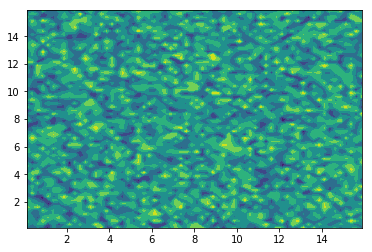

In [20]:
if btype=='w': # not supported anymore!
    plt.contourf( xb[:,1,:] , zb[:,1,:] , bi[:,1,:] + Bb[:,1,:])
elif btype=='c':
#    plt.contourf( xp[:,1,:] , zp[:,1,:] , ci[:,1,:]) 
    plt.contourf( xp[1,:,:] , yp[1,:,:] , ci[Nz//2,:,:]) 
print(btype)

<hr/>
# Set up the animation plot

In [21]:
# set up animation plot
myfig = plt.figure(figsize=(16,16),facecolor='lightgrey')

#ax1 = myfig.add_axes([0.1, 0.5, 0.4, .8*zmax/xmax],frameon=False) # vertical cross-section
xysz = .7
xcorner = 0.2 - xysz*zmax/ymax
ax1 = myfig.add_axes([xcorner, 0.2, xysz*zmax/ymax, xysz],frameon=False) # y-z vertical cross-section

#ax2 = myfig.add_axes([0.1, 0.1, 0.4, .8*zmax/xmax],frameon=False) # vertical cross-section
ycorner = 0.2 - xysz*zmax/xmax
ax2 = myfig.add_axes([0.2 ,ycorner, xysz, xysz*zmax/xmax],frameon=False) # x-z vertical cross-section
#ax3 = myfig.add_axes([0.02, 0.3, 0.05333, .5333]) # for colorbar
ax3 = myfig.add_axes([0.92, 0.3, 0.05333, .5333]) # for colorbar
ax4 = myfig.add_axes([0.2, 0.2, xysz, xysz*ymax/xmax],frameon=False) # x-y cross-section
ax0 = myfig.add_axes([0., 0.9, 1., .1],frameon=False)

ax3.axis('off')
ax1.axis('off')
ax2.axis('off')
ax4.axis('off')
ax0.axis('off')
#ax1 = myfig.add_axes([0.1, 0.0500, 0.5333, .2666]) # line plot axes
#plt.setp( ax2.get_xticklabels(), visible=False);
cbar_exists=False
plt.close()

In [22]:
#bcolors = np.arange(0,bcmax/2+1)*bcinc - bcmax
blevs = -bcmax+2*np.arange(0,bcmax+.1,bcinc//2)
wctot = 120
wlevs = np.arange(wctot)*wcinc -(wctot-1)*wcinc/2
zetainc=4.
zetatot=120
zetalevs = np.arange(zetatot)*zetainc -(zetatot-1)*zetainc/2
zetacolors = blevs.copy() # for vertical vorticity filled contours
print(blevs)
print(wlevs)
print(zetacolors)

[-30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.  22.
  26.  30.]
[-11.9 -11.7 -11.5 -11.3 -11.1 -10.9 -10.7 -10.5 -10.3 -10.1  -9.9  -9.7
  -9.5  -9.3  -9.1  -8.9  -8.7  -8.5  -8.3  -8.1  -7.9  -7.7  -7.5  -7.3
  -7.1  -6.9  -6.7  -6.5  -6.3  -6.1  -5.9  -5.7  -5.5  -5.3  -5.1  -4.9
  -4.7  -4.5  -4.3  -4.1  -3.9  -3.7  -3.5  -3.3  -3.1  -2.9  -2.7  -2.5
  -2.3  -2.1  -1.9  -1.7  -1.5  -1.3  -1.1  -0.9  -0.7  -0.5  -0.3  -0.1
   0.1   0.3   0.5   0.7   0.9   1.1   1.3   1.5   1.7   1.9   2.1   2.3
   2.5   2.7   2.9   3.1   3.3   3.5   3.7   3.9   4.1   4.3   4.5   4.7
   4.9   5.1   5.3   5.5   5.7   5.9   6.1   6.3   6.5   6.7   6.9   7.1
   7.3   7.5   7.7   7.9   8.1   8.3   8.5   8.7   8.9   9.1   9.3   9.5
   9.7   9.9  10.1  10.3  10.5  10.7  10.9  11.1  11.3  11.5  11.7  11.9]
[-30. -26. -22. -18. -14. -10.  -6.  -2.   2.   6.  10.  14.  18.  22.
  26.  30.]


In [23]:
def doplot(ip=None,jp=None,kp=None,vectors=True,kz=None,overwrite=False):
    global cbar_exists
    
    ax1.clear()
    ax2.clear()
    ax4.clear()
    ax0.clear()
    ax3.clear()
    
    
    cextn[1:-1] = c

    hprime = 0.
    if gamma!= 0.:
        cbar = cextn[1].mean()
        cprime = cextn[1] - cbar
        hprime = - gamma* cprime
    cextn[0] = (hfbot+hprime)/diffusion_coef*dz*.5 + cextn[1]
    cextn[-1] = -(hftop)/diffusion_coef*dz*.5 + cextn[-2]
    
    U=u_to_p(u)
    V=v_to_p(v)
    W=w_to_p(w)
     
    # HORIZONTAL CROSS-SECTION

    if kp is None: kp=Nz//2 # 
        
    ax4.clear()
    
    # note: maxind will be used in the vertical cross sections
    if btype == 'w': # not supported
        ax4.contourf( xb[kp,:,:], yb[kp,:,:], b[kp,:,:] + Bb[kp,:,:] , blevs, zorder=1)
        maxind = np.unravel_index( np.argmax(b[kp,:,:] , axis=None), b[kp,:,:].shape) 
    elif btype =='c':
        cmid = 0.5*(c[kp,:,:]+c[kp-1,:,:])
        ax4.contourf( xp[kp,:,:], yp[kp,:,:],cmid, blevs, zorder=1)
        maxind = np.unravel_index(np.argmax(cmid, axis=None), cmid.shape)
        
    ax4.contour( xw[kp,:,:], yw[kp,:,:], w[kp,:,:], wlevs, colors=['k',], zorder=3)
    
    zeta = (vu[:,:,1:] - vu[:,:,:-1])/dx - (uv[:,1:,:] - uv[:,:-1,:])/dy
    if kz and zeta[kz].max()>zeta[kz].min(): 
#        ax4.contour( xp[kz,:,:], yp[kz,:,:], zeta[kz] , zetalevs, colors =['r',])
        ax4.contourf( xp[kz,:,:], yp[kz,:,:], zeta[kz] , zetacolors,zorder=1)
        vd = 1
        ax4.quiver(xp[ kz, ::vd,::vd], yp[kz,::vd,::vd], U[kz,::vd,::vd], V[kz,::vd,::vd],
            scale=1.0*Nx/vd,units='width',zorder=3,color='black')
    else:
        ax4.contourf( xp[kp,:,:], yp[kp,:,:],cmid, blevs, zorder=1)

        
    #vd=1
    #speedmax=1 # anticipate value of max    
    #_at_p = (u[kp,:,:-1]+u[kp,:,1:])*.5
    #_at_p = (v[kp,:-1,:]+v[kp,1:,:])*.5
    #Q2 = ax4.quiver(xp[ 1, ::vd,::vd], yp[kp,::vd,::vd], u_at_p[::vd,::vd], v_at_p[::vd,::vd],
     #   scale=speedmax*Nx/vd,units='width',zorder=3,color='black')   
    #speedf= "%7.3f"  % speedmax
    #ax4.quiverkey(Q2,.5,-.04 , speedmax, speedf,zorder=4, color='red', fontproperties={'size':12} )
    
    locz = "z=%4.2f" % zb[kp,0,0]
###    ax4.text(.83*xmax, -.04*ymax, locz, fontsize=18)
###    ax4.text(0,-.05*ymax,'t={0:5.2f}'.format(t),fontsize=22)
#    ax4.text(.83*xmax, 1.04*ymax, locz, fontsize=18)

    ax0.text(.81,.8,'t={0:5.2f}'.format(t),fontsize=30)
    
    expt = "%4.1f  %d,%d,%d    $\Gamma=$%5.3f    $\\beta=$%4.1f     $\epsilon$=%6.4f    $R/Rc$=%5.1f " % \
    (xmax, Nx,Ny,Nz,gamma,beta,diffusion_coef,ray_over_rayc)
    ax0.text(.1, .8, expt, fontsize=24)
    dtf = 'dt=%.5f  k=%d' % (dt,kp)
    ax0.text(.7,.5,dtf,fontsize=14)
       
    
    
    if True:  #xz cross-section     
        if jp is None: jp=maxind[0]
        

#        ax2.contour(xp[:,jp,:],zp[:,jp,:],p[:,jp,:],.1*np.linspace(-2.1,2.1,22),colors=['w',],zorder=2)

        if btype == 'c':
         #   CF = ax2.contourf(xp[:,jp,:] , zp[:,jp,:] , c[:,jp,:] , bcolors,zorder=1)
            CF = ax2.contourf(xextn[:,jp,:] , zextn[:,jp,:] , cextn[:,jp,:] , blevs,zorder=1)
        elif btype == 'w':
            CF = ax2.contourf(xb[:,jp,:] , zb[:,jp,:] , b[:,jp,:] + Bb[:,jp,:] ,blevs,zorder=1)
        #    ax2.contour(xp[:,jp,:] , zp[:,jp,:] , c[:,jp,:] , colors=['w',] , zorder=1) #both
        
        vd=1
        speedmax=1  # anticipate value of max  
#        u_at_p = (u[:,jp,:-1]+u[:,jp,1:])*.5
#        w_at_p = (w[:-1,jp,:]+w[1:,jp,:])*.5
        if vectors:
            Q = ax2.quiver(xp[::vd,jp,::vd] , zp[::vd,jp,::vd] , U[::vd,jp,::vd] , W[::vd,jp,::vd],
                scale=speedmax*Nx/vd,units='width',zorder=3,width=.002)
#        ax2.set_ylim(0,1)
        

        
    if True: #yz cross-section
        if ip is None: ip = maxind[1]
            
#        CF = ax1.contourf(yb[:,:,ip],zb[:,:,ip],this[:,:,ip],bcolors,zorder=1)
#        ax1.contour(yp[:,:,ip],zp[:,:,ip],p[:,:,ip],.1*np.linspace(-2.1,2.1,22),colors=['w',],zorder=2)
##        ax1.contour(yp[:,:,ip],zp[:,:,ip],c[:,:,ip]- strat*(.5-zp[:,:,ip])  ,bcolors,colors=['k',],zorder=3)
        if btype == 'c':
#####            CF = ax1.contourf(yp[:,:,ip] , zp[:,:,ip] , c[:,:,ip]  , bcolors,zorder=1)
#            CF = ax1.contourf(yextn[:,:,ip] , zextn[:,:,ip] , cextn[:,:,ip]  , bcolors,zorder=1)
            #CF = ax1.contourf( zextn[:,:,ip], yextn[:,-1::-1,ip], cextn[:,:,ip]  , bcolors,zorder=1)
            CF = ax1.contourf( zextn[:,:,ip], yextn[:,:,ip], cextn[:,:,ip]  , blevs,zorder=1)
        elif btype == 'w':
            ax1.contour(yb[:,:,ip] , zb[:,:,ip] , b[:,:,ip]+Bb[:,:,ip] , blevs,zorder=1)
    
        vd=1
        speedmax=1  # anticipate value of max  
#        v_at_p = (v[:,:-1,ip]+v[:,1:,ip])*.5
#        w_at_p = (w[:-1,:,ip]+w[1:,:,ip])*.5
###        Q1 = ax1.quiver(yp[::vd,::vd,ip],zp[::vd,::vd,ip],v_at_p[::vd,::vd],w_at_p[::vd,::vd],
###            scale=speedmax*Nx/vd,units='width',zorder=3)
        if vectors:
            Q1 = ax1.quiver(zp[::vd,::vd,ip],yp[::vd,::vd,ip],W[::vd,::vd,ip],V[::vd,::vd,ip],
                scale=speedmax*Ny/vd,units='height',color='k',zorder=4,width=.002)
#        ax1.set_ylim(0,1)
        
    speedf= "%7.3f"  % speedmax    
#    ax2.quiverkey(Q,.8*xmax,-.04*xmax,speedmax, speedf,zorder=4)
    
#    locy = "j=%d  y=%4.2f" % (jp, yb[0,jp,0])
#    ax2.text(.03*xmax, -.05*xmax, locy, fontsize=18)
#    locx = "i=%d  x=%4.2f" % (ip, xb[0,0,ip])
#    ax1.text(.53*xmax, -.05*xmax, locx, fontsize=18)
#    ax2.text(.53*xmax, -.05*xmax, locx, fontsize=18)
#    ax2.quiverkey(Q,-.1,.5, speedmax, speedf, zorder=4, color='red', fontproperties={'size':12}) 
    

    xlocmax = xp[0,0,ip]
    ylocmax = yp[0,jp,0]
    ax2.text(xlocmax,1.,'$\\uparrow$',horizontalalignment='center',zorder=0)
    ax1.text(1.,ylocmax,'$\\rightarrow$',horizontalalignment='center',verticalalignment='center',zorder=0)
    
#DIAGNOSTICS
#    U=u_to_p(u)
#    V=v_to_p(v)
#    W=w_to_p(w)
    if btype=='c':
        B = c
    elif btype=='w':
        B = w_to_p(b+Bb)   
    
    speed = np.sqrt(U*U + V*V + W*W)       
    kinEn = (.5*speed**2).mean()

    ke.append(kinEn)
    monitor1.append( zeta.max() )
    monitor2.append( zeta.min() )

    times.append(t)
    
    minmax = "%4.2f %s %4.2f"
    
    maxes1 = minmax % (U.min() ,'< u <',U.max())
    ax0.text(0.1, .5, maxes1 , fontsize=18)
    maxes1 = minmax % (V.min() ,'< v <',V.max())
    ax0.text(0.3, .5, maxes1 , fontsize=18)
    maxes1 = minmax % (W.min() ,'< w <',W.max())
    ax0.text(0.5, .5, maxes1 , fontsize=18)
    
    maxes1 = minmax % (cextn.min() ,'< c <',cextn.max())
    ax0.text(.1, .3, maxes1 , fontsize=18)
    maxes1 = minmax % (p.min() ,'< p <', p.max())
    ax0.text(.3, .3, maxes1 , fontsize=18)
    
    if kz : # plot vorticity
        maxes1 = minmax % (zeta[kz].min() ,'< $\\zeta$ <', zeta[kz].max())
        ax0.text(.5, .3, maxes1 , fontsize=18)
        
    if not cbar_exists: #bad things happen if cbar is called more than once 
        cbar_exists = True
        mycbar = myfig.colorbar(CF,ax=ax3,fraction=0.6,ticks=blevs)
        mycbar.ax.yaxis.set_ticks_position('left')
        sooner = mycbar.ax.yaxis.get_ticklabels()
        for boomer in sooner:
            boomer.set_fontsize(18)
    
    deltaw = '$\\Delta w=$%3.1f' % wcinc
    ax0.text(.7,.1,deltaw,fontsize=24)

    ax1.axis('off')
    stop_clipping(ax1)        
    ax2.axis('off')
    stop_clipping(ax2)
    ax4.axis('off')
    stop_clipping(ax4)
    ax0.axis('off')
    ax3.axis('off')

    clear_output(wait=True)

    display(myfig)   
    
    if outdir != None: 
        timestamp = round(t,2)
        pngname = outdir+'/%06d.png' % round(10*timestamp)
        print(pngname)
        if not os.path.exists(pngname) or overwrite:
            myfig.savefig(pngname, dpi=72, facecolor='w', edgecolor='w', orientation='portrait')  

In [24]:
## doplot(kz=Nz//8,overwrite=False,kp=Nz//8)

<hr/>
# Ready to run at t=0

In [25]:
#tstart = 6. # if needed to restart with tstart>0

if tstart==0:
    u=ui.copy()
    v=vi.copy()
    w=wi.copy()
    p=pi.copy() # not needed?
    c=ci.copy()
    t=0
    if outdir != None:
        if os.path.exists(outdir): 
            shutil.rmtree(outdir)
        os.mkdir(outdir)
        print("recreate directory:", outdir)
else:
    t = tstart
    timestamp = round(t,2)
    timestring = '%06d' % round(10*timestamp)
    print('attempt to load arrays from files in',outdir)
    c = np.load(outdir+'/c'+timestring+'.npy')
    u = np.load(outdir+'/u'+timestring+'.npy')
    v = np.load(outdir+'/v'+timestring+'.npy')
    w = np.load(outdir+'/w'+timestring+'.npy')
    p = np.load(outdir+'/p'+timestring+'.npy')   
    
#dbdta=[None]*3
dudta=[None]*3
dvdta=[None]*3
dwdta=[None]*3
dcdta=[None]*3

ke=[] # for time series of total kinetic energy in the domain
monitor1 = [] # for recording a diagnostic quantity at every time step
monitor2 = []

times = [] # time of the diagnostic
nstep = 0

 # interval between plots
tplot = t + dplot

dtlimad = 0.1*dz/anticipated_wmax 
dtlimdiff = .5*dz*dz/diffusion_coef
print('dtlimad',dtlimad,'    dtlimdiff',dtlimdiff)
dt = min(dtlimad,dtlimdiff )
print("using dt=",dt)
print("now t=",t)


recreate directory: R4g0w16
dtlimad 0.016666666666666666     dtlimdiff 0.30827650929130873
using dt= 0.016666666666666666
now t= 0


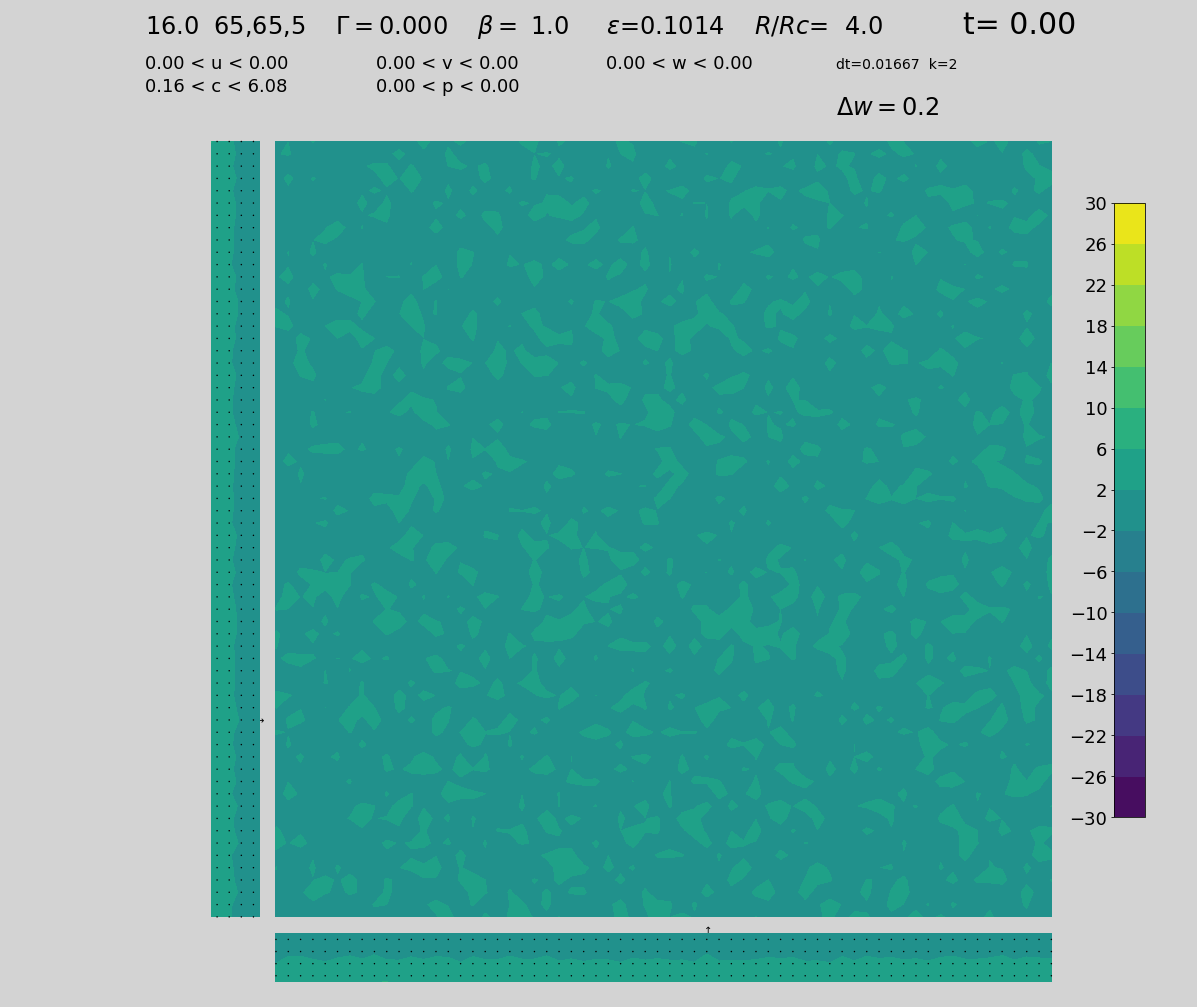

R4g0w16/000000.png


In [26]:
vu = v_to_u(v,'per')
uv = u_to_v(u,'per')
if t==0: doplot(kz=kz)

<hr/>
# Step forward in time

You can repeatedly increase `tstop` and rerun the following cell.

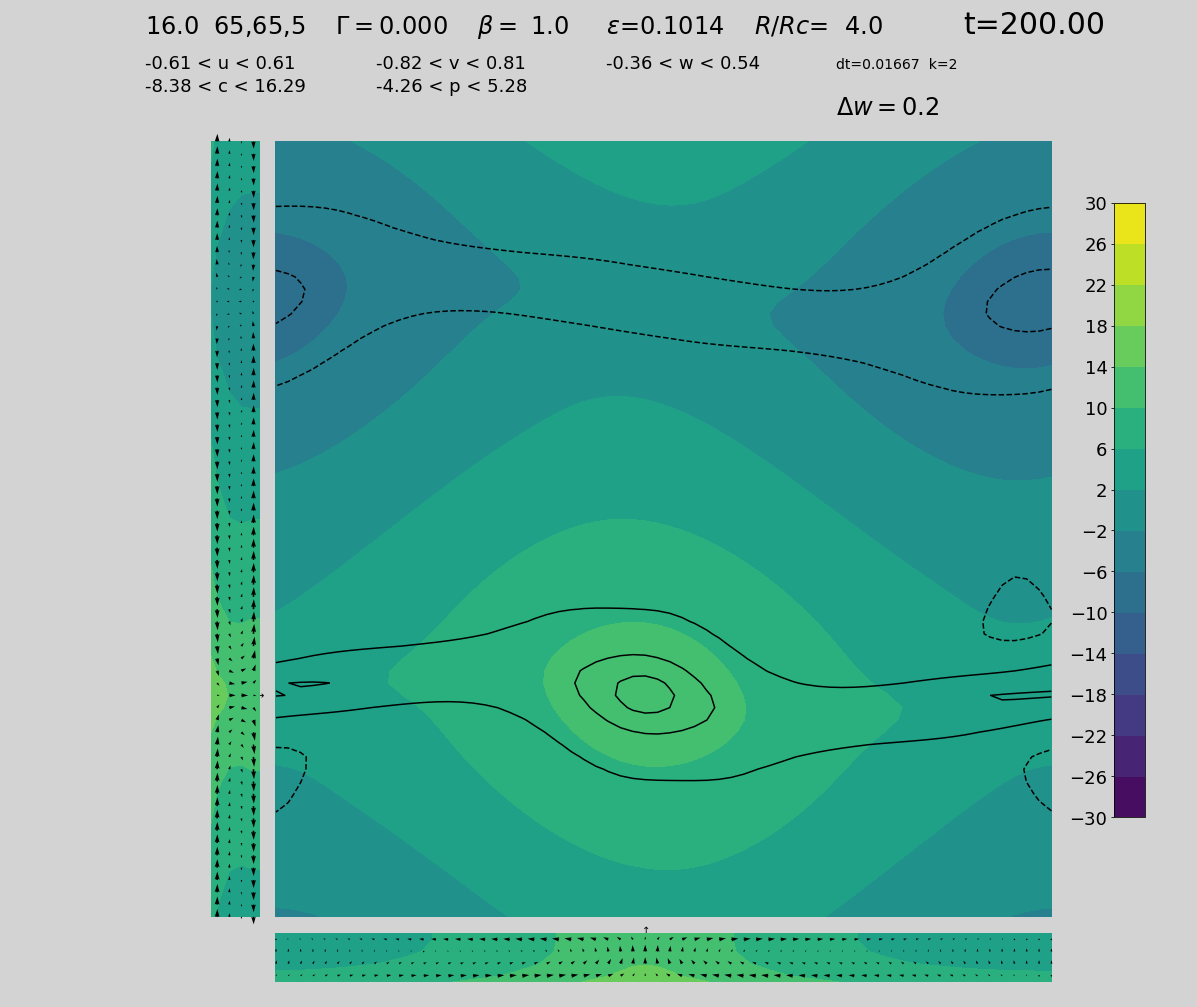

R4g0w16/002000.png


In [27]:
#dt=.001
# dplot = .1
tplot = t+ dplot
# normally, don't use commented lines above
tstop = tend  # change tstop and rerun this cell if needed

while t < tstop + dt/2.:
    
    bnd = 'slip'
    uw = u_to_w(u,bnd)
    vw = v_to_w(v,bnd)
    if periodic: bnd='per'
    vu = v_to_u(v,bnd)
    wu = w_to_u(w,bnd)
    uv = u_to_v(u,bnd)
    wv = w_to_v(w,bnd)
    
    if periodic:
        dudt =  advect_3dp(u,u,vu,wu,dx,dy,dz,'u')
        dvdt =  advect_3dp(v,uv,v,wv,dx,dy,dz,'v')
##        dbdt =  advect_3dp(b,uw,vw,w,dx,dy,dz,'w')
        dwdt =  advect_3dp(w,uw,vw,w,dx,dy,dz,'w')
        dcdt = fluxform(c,u,v,w,dx,dy,dz,hfbot,hftop,diffu=diffusion_coef,gamma=gamma)   # - w_to_p(w)*strat*(1-zp)
        dcdtavg= hfbot - hftop
        if dcdtavg!=0.:
            dcdt -= dcdtavg
        
###        dbdt += diffusion_coef*laplacian(b,dx,dy,dz,il=-1,ir=0,jb=-1,jt=0) # for zero b on boundaries
##        dbdt += diffusion_coef*laplacian(b,dx,dy,dz,il=-1,ir=0,jb=-1,jt=0,kb=1,kt=-2) # for zero flux b on boundaries
        dudt += diffusion_coef*laplacian(u,dx,dy,dz,il=-2,ir=1,jb=-1,jt=0,kb=0,kt=-1)      
        dvdt += diffusion_coef*laplacian(v,dx,dy,dz,il=-1,ir=0,jb=-2,jt=1,kb=0,kt=-1)
        dwdt += diffusion_coef*laplacian(w,dx,dy,dz,il=-1,ir=0,jb=-1,jt=0)
        
    else:
        dudt =  advect_3d(u,u,vu,wu,dx,dy,dz)
        dvdt =  advect_3d(v,uv,v,wv,dx,dy,dz)
##        dbdt =  advect_3d(b,uw,vw,w,dx,dy,dz)
        dwdt =  advect_3d(w,uw,vw,w,dx,dy,dz)
        
    if fcoriolis!=0.: dudt +=  fcoriolis*vu #Coriolis term 
    if fcoriolis!=0.: dvdt += -fcoriolis*uv #Coriolis term
        
    if btype == 'w': # nto supported anymore
        dwdt[1:-1] += b[1:-1]
        dbdt += -w*Bbz
    elif btype == 'c':
        dwdt[1:-1] += (c[:-1]+c[1:])*.5

# Ensure no normal component of velocity develops on the boundaries:
    if not periodic:
        dudt[:,:,0]=0.
        dudt[:,:,-1]=0.
        dvdt[:,0,:]=0.
        dvdt[:,-1,:]=0.
    dwdt[0,:,:]=0.
    dwdt[-1,:,:]=0.
    

    divaccel= div_Cgrid(dudt,dvdt,dwdt,dx,dy,dz)
    divvel = div_Cgrid(u,v,w,dx,dy,dz)

    p = poisson3d_p_fft(divaccel + .4*divvel/dt, inv_lapl_op, periodic=periodic)

    p = p - p.mean() 
    
    dudt[:,:,1:-1] += ( p[:,:,:-1] - p[:,:,1:] )/dx
    dvdt[:,1:-1,:] += ( p[:,:-1,:] - p[:,1:,:] )/dy
    dwdt[1:-1,:,:] += ( p[:-1,:,:] - p[1:,:,:] )/dz

    if periodic:
        dudt[:,:,0] += ( p[:,:,-1] - p[:,:,0] )/dx
        dvdt[:,0,:] += ( p[:,-1,:] - p[:,0,:] )/dy
        dudt[:,:,-1] = dudt[:,:,0] 
        dvdt[:,-1,:] = dvdt[:,0,:]         

    dudta=[dudt.copy()]+dudta[:-1]
    dvdta=[dvdt.copy()]+dvdta[:-1]
    dwdta=[dwdt.copy()]+dwdta[:-1]
#    dbdta=[dbdt.copy()]+dbdta[:-1]
    dcdta=[dcdt.copy()]+dcdta[:-1]
    
#   step forward in time:
    nstep += 1
    abnow = min(nstep,aborder)
##    b += dt*ab_blend(dbdta,abnow) 
    c += dt*ab_blend(dcdta,abnow) 
    u += dt*ab_blend(dudta,abnow) 
    v += dt*ab_blend(dvdta,abnow) 
    w += dt*ab_blend(dwdta,abnow) 
    t += dt
    

    if nodrift and periodic:
        u = u - u.mean()
        v = v - v.mean()
     
    if  tplot-dt/2. < t: # make plot and save arrays
        doplot(overwrite=True,kz=kz,kp=kp)
        tplot = tplot + dplot
        timestamp = round(t,2)
        timestring = '%06d' % round(10*timestamp)
        np.save(outdir+'/c'+timestring,c)
        np.save(outdir+'/u'+timestring,u)
        np.save(outdir+'/v'+timestring,v)
        np.save(outdir+'/w'+timestring,w)
        np.save(outdir+'/p'+timestring,p)
plt.close()

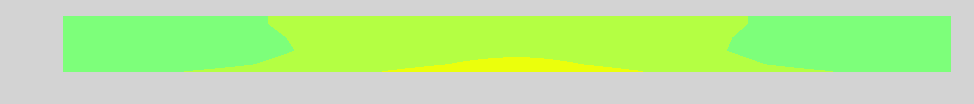

0.0


In [41]:
cextn[1:-1] = c

hprime = 0.
if gamma!= 0.:
    cbar = cextn[1].mean()
    cprime = cextn[1] - cbar
    hprime = - gamma* cprime

cextn[0] = (hfbot+hprime)/diffusion_coef*dz*.5 + cextn[1]
cextn[-1] = -(hftop)/diffusion_coef*dz*.5 + cextn[-2]

jp = 1

xfig = plt.figure(figsize=(16,8),facecolor='lightgrey')

bx2 = xfig.add_axes([0.1, 0.1, 0.8, 1.6*zmax/xmax],frameon=False) # vertical cross-section
#plt.close()
jp=2
bx2.contourf(xextn[:,jp,:] , zextn[:,jp,:] , cextn[:,jp,:] , blevs,zorder=1)
bx2.contour(xw[:,jp,:] , zw[:,jp,:] , w[:,jp,:] , wlevs, colors=['k',], zorder=2)
bx2.axis('off')
stop_clipping(bx2)

clear_output(wait=True)

display(xfig) 
plt.close()
print(gamma)

In [42]:
# check heat flux at bottom
diffusion_coef*(cextn[0].mean()-cextn[1].mean())/(.5*dz)

0.99999999999999944

In [43]:
#kv=2
vu = v_to_u(v,'per')
uv = u_to_v(u,'per')
zeta = (vu[:,:,1:] - vu[:,:,:-1])/dx - (uv[:,1:,:] - uv[:,:-1,:])/dy
#plt.contour( xp[kv,:,:], yp[kv,:,:], zeta[kv] , zetalevs,colors =['k',])

In [44]:
zeta.min(),zeta.max()

(-0.23775744115828745, 0.18248115741263832)

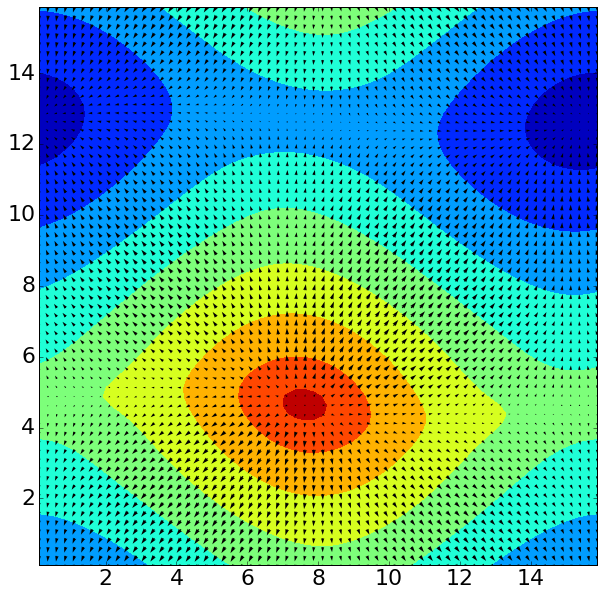

In [45]:
vd=1
U=u_to_p(u)
V=v_to_p(v)
kh=3
more,this=plt.subplots(figsize=[10,10])
this.contourf(xp[kh],yp[kh],p[kh])
this.quiver(xp[ kh, ::vd,::vd], yp[kh,::vd,::vd], U[kh,::vd,::vd], V[kh,::vd,::vd],
        scale=1.0*Nx/vd,units='width',zorder=3,color='black');  

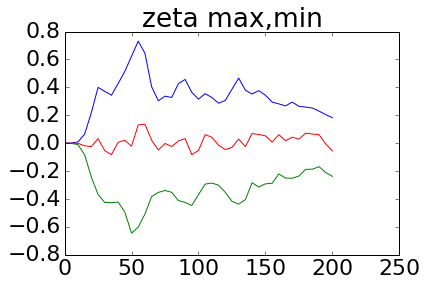

In [46]:
plt.close()
d = []
for n in range(len(monitor1)):
    d.append(monitor1[n]-abs(monitor2[n]))
plt.plot(times,monitor1)
plt.plot(times,monitor2)
plt.plot(times,d)

plt.title("zeta max,min");

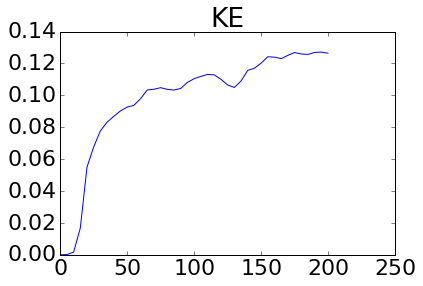

In [47]:
plt.plot(times,ke)
plt.title("KE");

In [48]:
divvel=div_Cgrid(u,v,w,dx,dy,dz)
print("should be small:",divvel.max(),divvel.min())

should be small: 5.55111512313e-15 -5.21804821574e-15


In [49]:
nloopmax = 0 # zero prevent this cell from running, set to 1 to see animation 
pngdir = outdir
#pngdir = 'gamma0'
pngs = glob.glob(pngdir+'/*.png')
pngs.sort()
n=0

nloop = 0
while nloop<nloopmax:
    png=pngs[n]
    if not os.path.exists(png):
        print("could not find:",png)  
        break
    n+=1
    if n>=len(pngs):
        n = 0
        nloop+=1
    display(Image(filename=png))
    Time.sleep(0.5)
    clear_output(wait=True)
print("completed",nloop,"loops of animation",outdir)

completed 0 loops of animation R4g0w16


# External animation

In [50]:
from janim import makeanim
import glob

In [51]:
pngdir = outdir
#pngdir = 'r4w32'
pngs = glob.glob(pngdir+'/*.png') # the * matches anything
pngs.sort()
#if using Windows, get rid of file paths that use \
pngsfixed = [x.replace('\\','/') for x in pngs] # fixes Windows
#print(pngs)
#print(pngsfixed)
print( pngsfixed[-10:] )

['R4g0w16/001550.png', 'R4g0w16/001600.png', 'R4g0w16/001650.png', 'R4g0w16/001700.png', 'R4g0w16/001750.png', 'R4g0w16/001800.png', 'R4g0w16/001850.png', 'R4g0w16/001900.png', 'R4g0w16/001950.png', 'R4g0w16/002000.png']


In [52]:
htmlfile=pngdir+".html"
makeanim(pngsfixed,outfile=htmlfile,sortOrder=True,
         ctlOnSide=True,titlestring="Animation of Cell Broadening")
display( Markdown( "to see your animation, open in New Tab: ["+htmlfile+"]("+htmlfile+")" ) )

to see your animation, open in New Tab: [R4g0w16.html](R4g0w16.html)

## Appendix

In [53]:
import math

In [54]:
# for constant b:
rayc = 27/4 * math.pi**4
kcrit = math.pi/math.sqrt(2)
lambdacrit = 2*math.pi/kcrit
epsicrit = 1/math.sqrt(rayc) # for dB/dz = -1
epsicrit = math.sqrt(rayc)**(-1/3) # for dB/dz = -1/epsicrit
constantflux=True

if constantflux:
    raycrit=240/(hfbot+hftop)
    diffusion_crit = raycrit**(-1/3)
else:
    raycrit = 27/4*math.pi**4
    diffusion_crit = 1/math.sqrt(raycrit) # for dB/dz = -1

#    diffusion_crit = math.sqrt(raycrit)**(-1/3) # for dB/dz = -1/epsicrit
 

In [55]:
# free slip,  Rayleigh-Benard with constant T
rayc = 27/4 * math.pi**4
print(rayc)
kcrit = math.pi/math.sqrt(2)
print(kcrit)
lambdacrit = 2*math.pi/kcrit
print(lambdacrit)
epsicrit = 1/math.sqrt(rayc) # with db/dz = -1
print(epsicrit)

657.5113644795163
2.221441469079183
2.8284271247461903
0.038998541767010154


In [56]:
# free slip, constant flux

raycrit = 120
#with db/dz = -1:
epscrit = 1./math.sqrt(raycrit)
print(epscrit)

# with dbdz = -1/eps:
epscrit = raycrit**(-1/3)
print(epscrit)

# with dbdz = -1+z
raycrit = 240
epscrit = 1./math.sqrt(raycrit)
print(epscrit)

# with dbdz = (-1+z)/eps 
epscrit = raycrit**(-1/3)
print(epscrit)


0.09128709291752768
0.20274006651911336
0.06454972243679027
0.16091489743427165
